In [1]:
from mahotas.features import surf
from sklearn.neighbors import NearestNeighbors
import cv2
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import norm
from skimage.transform import resize
import glob, os
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans

In [2]:
def find_surf(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = resize(img, (320, 240))
    spoints = surf.surf(img, descriptor_only=True, nr_octaves=4, nr_scales=5, initial_step_size=1, threshold=1e-8, max_points=1024)
    descrs = spoints
    return descrs

# Compute features for every image

In [3]:
limit = 1000
list_files = []
image_features = []
features_list = []

for file in tqdm(glob.glob(str(os.getcwd())+"\images\*")):
    features = find_surf(cv2.imread(file))
    if len(features)>0:
        for feature in features:
            features_list.append(feature)
        list_files.append(file)
        image_features.append(features)
        if len(image_features) == limit:
            break

image_features = np.array(image_features)

# Make clusters for visual bag of words

In [4]:
n_clusters = 100

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features_list)

In [5]:
feature_vocab = kmeans.cluster_centers_
num_words = feature_vocab.shape[0]

In [6]:
from sklearn.neighbors import KDTree

def closest_word_vocab(feature_vocab):
    tree = KDTree(feature_vocab,leaf_size=1000)     
    return tree

tree_vocab = closest_word_vocab(feature_vocab)

In [7]:
list_hist = np.zeros((limit, n_clusters))

for i in range (limit):
        descrs = image_features[i]
        dist, ind = tree_vocab.query(descrs, k=1)
        hist = np.zeros(num_words)
        unique_words, count_words = np.unique(ind, return_counts=True)
        hist[unique_words] = count_words
        list_hist[i,:] = hist
        
idf = np.sum(list_hist > 0, axis=0)
idf = np.log(limit / idf)

list_hist = list_hist * idf
list_hist = np.sqrt(list_hist)
list_hist = (list_hist.T / np.linalg.norm(list_hist, axis = 1)).T

# Search

In [10]:
def matching_score(query_hist):
    scores = np.zeros((1,limit))
    for i in range (limit):
        scores[0,i]=np.dot(query_hist, list_hist[i])
    return scores

def search(img_name):
    query_img = cv2.imread('images/' + img_name)
    plt.imshow(query_img)
    
    descrs = find_surf(query_img)
    _, indexes = tree_vocab.query(descrs, k=1)
    query_hist = np.zeros(num_words)
    unique_words, count_words = np.unique(indexes, return_counts=True)
    
    # process histogram
    query_hist[unique_words] = count_words
    query_hist = query_hist * idf
    query_hist = np.sqrt(query_hist)
    query_hist = query_hist/np.linalg.norm(query_hist)

    scores=matching_score(query_hist)
    
    # sort in descending order
    scores_sorted_idx = np.argsort(-scores)
    scores_sorted = scores.ravel()[scores_sorted_idx]
    
    # plot top matches
    N=10
    top_N_idx = scores_sorted_idx.ravel()[:N]

    plt.figure()
    for i in range(N):

        file = list_files[top_N_idx[i]]    
        img = cv2.imread(file)
        # choose subplot
        plt.subplot(int(np.ceil(N/5)),5,i+1)
        # plot
        plt.imshow(img)
        plt.axis('off')
        plt.title('score %1.2f' % scores_sorted.ravel()[i])

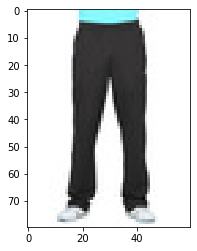

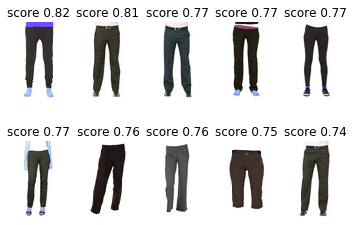

In [12]:
search('2105.jpg')